<a href="https://colab.research.google.com/github/wwk45/bert/blob/main/BERT_reddit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**BERT - Bidirectional Encoder Representations from Transformers**


---



Language Models try to “fill in the blank” based on context

“The woman went to the store and bought a _____ of shoes.”

---

Before BERT, languange models would look at sequence unidirectionally

BERT is bi-directionally trained. BERT uses Masking, masks random words and tries to predict them. 

Takes into account both previous and next tokens

---

BERT is based on the Transformer model architecture

Transformer works by performing a small, constant number of steps. Each step applies attention mechanism to understand relationship between all words in a sentence

---

“I arrived at the bank after crossing the river” 


In [ ]:
!pip install transformers
!pip install praw

from transformers import TFAutoModelForTokenClassification, AutoTokenizer 
from matplotlib import pyplot as plt 
import tensorflow as tf 
import praw 
from wordcloud import WordCloud


model = TFAutoModelForTokenClassification.from_pretrained("dbmdz/bert-large-cased-finetuned-conll03-english") #Our BERT pre-trained model :)
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased") 

We obtain an instance of the reddit class by using the PRAW.
Reddit instance:
  i) read-only
  ii)authorized

In [ ]:
categories = ["O", "B-MISC", "I-MISC", "B-PER", "I-PER", "B-ORG", "I-ORG", "B-LOC", "I-LOC"]

reddit = praw.Reddit(client_id='Mm4cv9Uvh0QUEw', client_secret='deo-CJ9u_QY8VLWOVWtapjXiCYvVqw', user_agent='Wajahat Khan')

In [ ]:
def comment_replies(top_comm, list_of_comments):
    if len(top_comm.replies) == 0:
        return
    else:
        for num, comment in enumerate(top_comm.replies):
            try:
                list_of_comments.append(str(comment.body))
            except:
                continue
            comment_replies(comment, list_of_comments) #recursive function

BERT model trained for 4 types of entities:
1. LOC
2. ORG
3. PER
4. MISC

In [ ]:
list_of_subreddit = ['India','Politics']
count = 0
final_dict = {'I-LOC': [], 'I-ORG': [], 'I-PER': [], 'B-LOC': [], 'B-ORG': [], 'B-PER': []} #BERT tags present in pre-trained model
temp_word = ''
current_tag = ''
old_tag = ''
print_dic = {}
list_of_comments = [] # Will use this to store our fetched data

In [ ]:
for j in list_of_subreddit:
    # We getting the top posts for last month and limiting it to 1
    top_posts = reddit.subreddit(j).top('month', limit=1) 
    for submission in top_posts:
        print('\n')
        print("Title :" , submission.title)
        submission_instance = reddit.submission(id=submission.id)
        list_of_comments.append(str(submission.title))

        for count, top_comm in enumerate(submission_instance.comments):
            try:
                comment_replies(top_comm, list_of_comments) # top level comment is id of comment
            except:
                continue




Title : Hyderabad cop running for 2 km to help ambulance get through traffic


Title : Megathread: Joe Biden Projected to Defeat President Donald Trump and Win the 2020 US Presidential Election


In [ ]:
print("\n\n\n Given below are the comments extracted\n")
print(list_of_comments)




 Given below are the comments extracted

['Hyderabad cop running for 2 km to help ambulance get through traffic', 'Not all cops are bad.', 'It is actually the system which breeds bad cops. The system gives cops near immunity for crimes. Cops should be held at the same (if not higher) standard for law and order...\n\nBut hats off to this guy. Also, why are people so stupid to not let an ambulance through?! SMH', "I've noticed that ambulances in India don't have very loud sirens. In other countries the ambulance sirens are so loud they are heard for almost a km.", "Let's also talk about these people who are right in front of the ambulance, but continue to hold their place ahead. There is a person dying, and I am sure they can hear the siren right behind them, they do not move over and wait for the ambulance to pass, this is abysmal & callous human behavior.", 'Where? I only see the auto driver do that here. In fact most of the vehicles are trying to make way for the ambulance', 'Look 



BERT uses BPE based Wordpiece Tokenisation, out of vocabulary word into subwords

Predicts if next sentence random or connected

---



Token embeddings: A [CLS] token is added to the input word tokens at the beginning of the first sentence and a [SEP] token is inserted at the end of each sentence.

Segment embeddings: A marker indicating Sentence A or Sentence B is added to each token. This allows the encoder to distinguish between sentences.

Positional embeddings: A positional embedding is added to each token to indicate its position in the sentence.

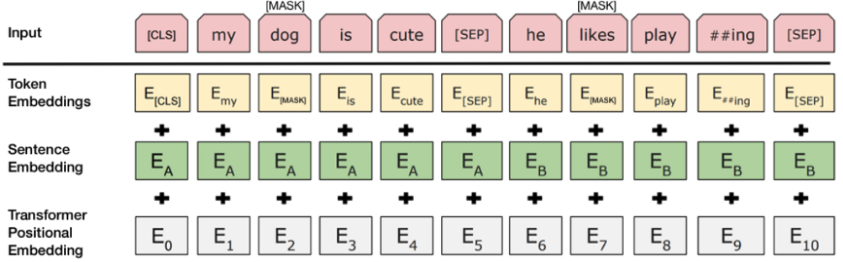

In [ ]:
for sequence in list_of_comments:
    if len(sequence) > 512: # Comment more than 512, we skip, cuz BERT cannot work with that
        continue
    tokens = tokenizer.tokenize(tokenizer.decode(tokenizer.encode(sequence)))
    print("\nThese are the tokens:")
    print(tokens)
    inputs = tokenizer.encode(sequence, return_tensors="tf")
    print("\nThese are the inputs:")
    print(inputs)
    outputs = model(inputs)[0]
    #print("\nThese are the outputs:")
    #print(outputs)
    predictions = tf.argmax(outputs, axis=2)
    sequence_bert = [(token, categories[prediction]) for token, prediction in zip(tokens, predictions[0].numpy())]
    print("\nThese is the sequence_bert:")
    print(sequence_bert)
    for i in sequence_bert: 
        if i[1] in ['O', 'B-MISC', 'I-MISC']:
            if len(current_tag) > 0:
                word_remove_whitespace = temp_word.strip()
                if len(word_remove_whitespace) > 1:
                    final_dict[current_tag].append(word_remove_whitespace)
            temp_word = ''
            current_tag = ''
            continue
        else:
            current_tag = i[1]

            if old_tag != current_tag and len(old_tag) > 0:
                word_remove_whitespace = temp_word.strip()
                if len(word_remove_whitespace) > 1:
                    final_dict[old_tag].append(word_remove_whitespace)
                temp_word = ''
                current_tag = ''

            if i[0].startswith('##'): 
                temp_word += i[0][2:].upper()
            elif i[1] in ['I-PER', 'I-ORG', 'I-LOC', 'B-LOC', 'B-ORG', 'B-PER']:
                temp_word += " " + i[0].upper()
                current_tag = i[1]
            old_tag = current_tag


These are the tokens:
['[CLS]', 'Hyderabad', 'cop', 'running', 'for', '2', 'km', 'to', 'help', 'ambulance', 'get', 'through', 'traffic', '[SEP]']

These are the inputs:
tf.Tensor(
[[  101 14033  9947  1919  1111   123  1557  1106  1494 13342  1243  1194
   3404   102]], shape=(1, 14), dtype=int32)

These is the sequence_bert:
[('[CLS]', 'O'), ('Hyderabad', 'I-LOC'), ('cop', 'O'), ('running', 'O'), ('for', 'O'), ('2', 'O'), ('km', 'O'), ('to', 'O'), ('help', 'O'), ('ambulance', 'O'), ('get', 'O'), ('through', 'O'), ('traffic', 'O'), ('[SEP]', 'O')]

These are the tokens:
['[CLS]', 'Not', 'all', 'cops', 'are', 'bad', '.', '[SEP]']

These are the inputs:
tf.Tensor([[  101  1753  1155 11396  1132  2213   119   102]], shape=(1, 8), dtype=int32)

These is the sequence_bert:
[('[CLS]', 'O'), ('Not', 'O'), ('all', 'O'), ('cops', 'O'), ('are', 'O'), ('bad', 'O'), ('.', 'O'), ('[SEP]', 'O')]

These are the tokens:
['[CLS]', 'It', 'is', 'actually', 'the', 'system', 'which', 'breeds', 'bad', 'cop

In [ ]:
print("Given below are all of the keywords we found along with their duplicates\n\n")
print(final_dict)
print_dic['Location'] = list(set(final_dict['I-LOC'] + final_dict['B-LOC']))
print_dic['Organisation'] = list(set(final_dict['I-ORG'] + final_dict['B-ORG']))
print_dic['Person Name'] = list(set(final_dict['I-PER'] + final_dict['B-PER']))
print("\n\n\n\nNow we printing all keywords by deleting duplicates and we categorize them based on Location, Organisation and Person Name\n")
print("Location:")
print(print_dic['Location'])
print("\nOrganisation:")
print(print_dic['Organisation'])
print("\nPerson Name:")
print(print_dic['Person Name'])

Given below are all of the keywords we found along with their duplicates


{'I-LOC': ['HYDERABAD', 'INDIA', 'INDIA', 'INDIA', 'INDIA', 'HYDERABAD', 'INDIA', 'HITECH CITY', 'SECUNDERABAD', 'INDIA', 'DIA', 'AMERICA', 'US', 'ERIC', 'USA', 'CANADA', 'EUROPE', 'US', 'INDIA', 'USA', 'INDIA', 'AMERICA', 'AMERICA', 'INDIA', 'INDIA', 'SOUTH AMERICA', 'TAMBARAM', 'INDIA', 'HYDERABAD', 'YDERABAD', 'MUMBAI', 'PUNE', 'YDERABAD', 'KALYAN', 'BANGALORE', 'DIA', 'GEORGIA', 'AMERICA', 'PHILLY', 'PA', 'FOUR SEASONS HOTEL', 'FOUR SEASONS HOTEL', 'PHILADELPHIA', 'GEORGIA', 'GA', 'KAPOWZ', 'EBENEZER BAPTIST CHURCH', 'DENMARK', 'DENMARK', 'DENMARK', 'DENMARK', 'PA', 'NEW YORK', 'PA', 'ALLEGHENY COUNTY', 'PITTSBURGH', 'EARTH', 'SAN FRANCISCO', 'PENNSYLVANIA', 'GONDOR', 'GEORGIA', 'GEORGIA', 'GEORGIA', 'US', 'UK', 'GA', 'AMERICA', 'DC', 'PENNSYLVANIA AVENUE', 'AMERICA', 'OVAL OFFICE', 'USA', 'PHILADELPHIA', 'PHILLY', 'PITTSBURGH', 'ERIE'], 'I-ORG': ['ACTIVA / ACCESS', 'PRS LEGISLATIVE', 'ACAB', 'ACAB', 'EM', '

In [ ]:
keywords = list(final_dict['I-LOC'] + final_dict['B-LOC'] + final_dict['I-ORG'] + final_dict['B-ORG'] + final_dict['I-PER'] + final_dict['B-PER'])
result_dict = {}

for keyword in keywords:
  if keyword not in result_dict:
    result_dict[keyword] = 1
  else:
    result_dict[keyword] += 1

#result_dict = sorted(result_dict.items(), key = lambda x: x[1], reverse=True)

print("These are all the key words along with the occurences of each keyword")
print(result_dict)


These are all the key words along with the occurences of each keyword
{'HYDERABAD': 3, 'INDIA': 11, 'HITECH CITY': 1, 'SECUNDERABAD': 1, 'DIA': 2, 'AMERICA': 6, 'US': 3, 'ERIC': 1, 'USA': 3, 'CANADA': 1, 'EUROPE': 1, 'SOUTH AMERICA': 1, 'TAMBARAM': 1, 'YDERABAD': 2, 'MUMBAI': 1, 'PUNE': 1, 'KALYAN': 1, 'BANGALORE': 1, 'GEORGIA': 5, 'PHILLY': 2, 'PA': 3, 'FOUR SEASONS HOTEL': 2, 'PHILADELPHIA': 2, 'GA': 2, 'KAPOWZ': 1, 'EBENEZER BAPTIST CHURCH': 1, 'DENMARK': 4, 'NEW YORK': 1, 'ALLEGHENY COUNTY': 1, 'PITTSBURGH': 2, 'EARTH': 1, 'SAN FRANCISCO': 1, 'PENNSYLVANIA': 1, 'GONDOR': 1, 'UK': 1, 'DC': 1, 'PENNSYLVANIA AVENUE': 1, 'OVAL OFFICE': 1, 'ERIE': 1, 'ACTIVA / ACCESS': 1, 'PRS LEGISLATIVE': 1, 'ACAB': 2, 'EM': 1, 'KALYAN RTO': 1, 'SENATE': 3, 'FOUR SEASONS': 1, 'FSP': 2, 'ADE': 1, 'PHI': 1, 'LAWN AND ORDER': 1, 'WENDY ’ S': 1, 'FOUR SEASONS LANDSCAPING': 1, 'LMFAO': 1, 'SEASONS LANDSCAPING': 1, 'DNC': 1, 'DJT': 1, 'FOX': 1, 'BES': 1, 'CONGRESS': 2, 'SUPREME COURT': 1, 'GREY ROCK': 1, 'T

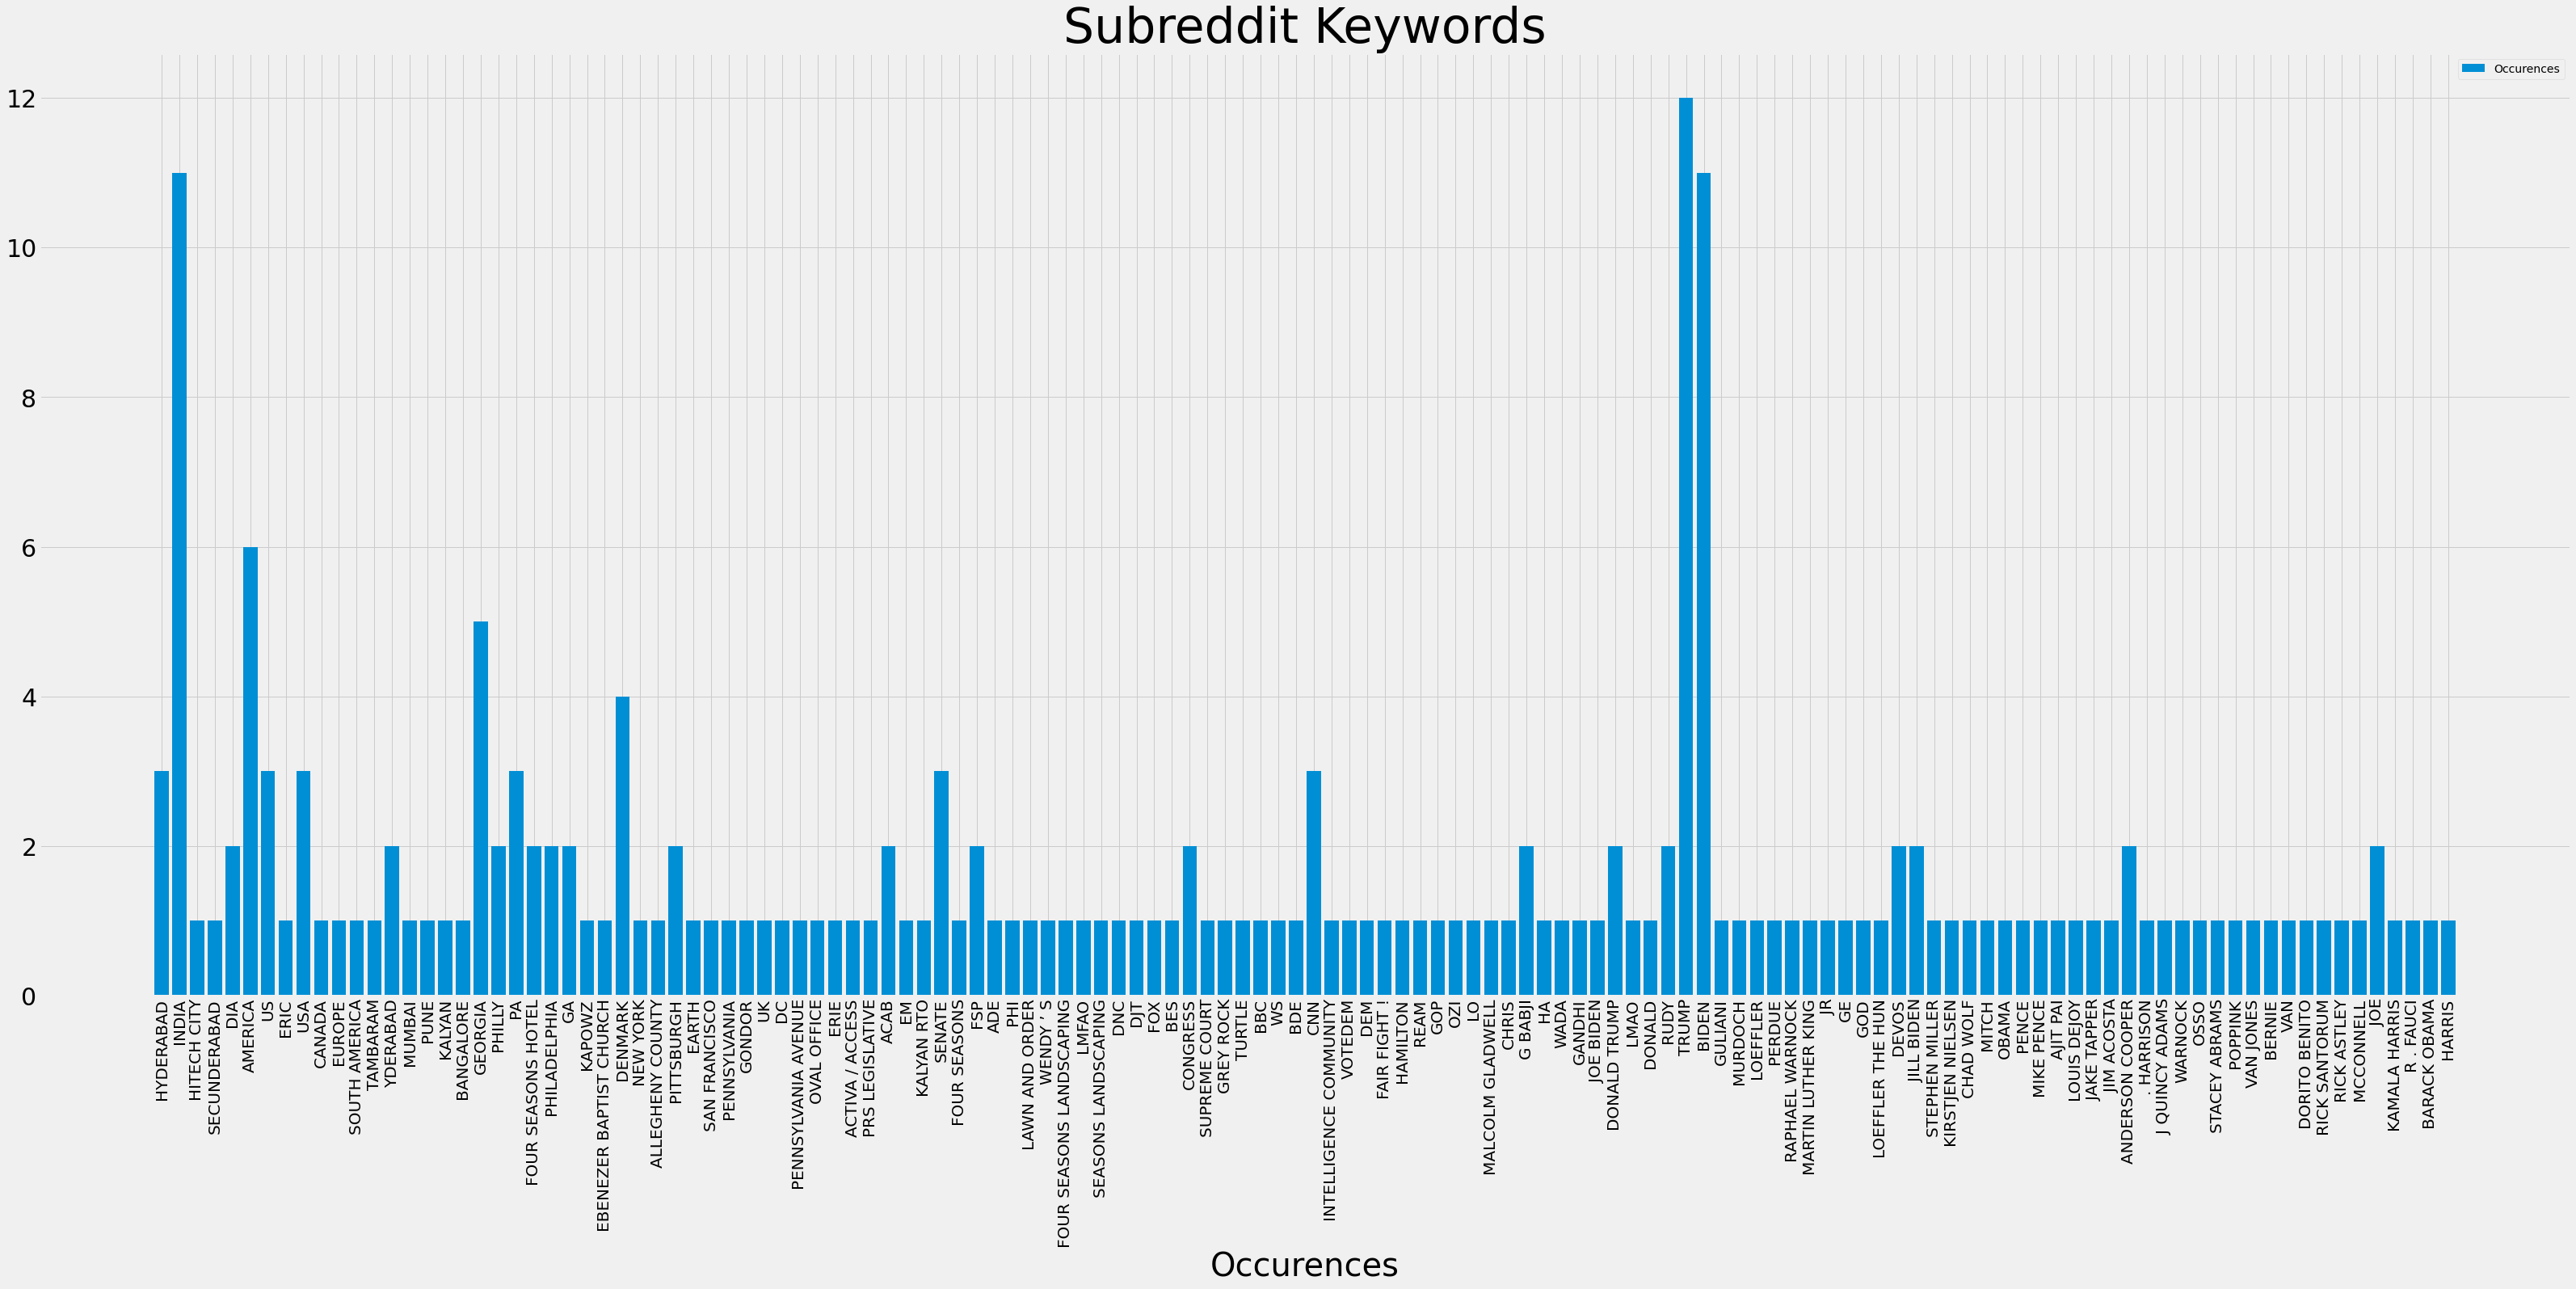

In [ ]:
width = 50
height = 20

x_axis = range(len(result_dict))

plt.style.use('fivethirtyeight') 

plt.figure(figsize=(width, height))
plt.bar(x_axis, list(result_dict.values()), label="Occurences")

plt.xticks(x_axis, list(result_dict.keys()), rotation=90, fontsize=20)
plt.yticks(fontsize = 30)

plt.title("Subreddit Keywords", fontsize=60)
plt.xlabel("Keywords", fontsize=40)
plt.xlabel("Occurences", fontsize=40)

plt.legend()

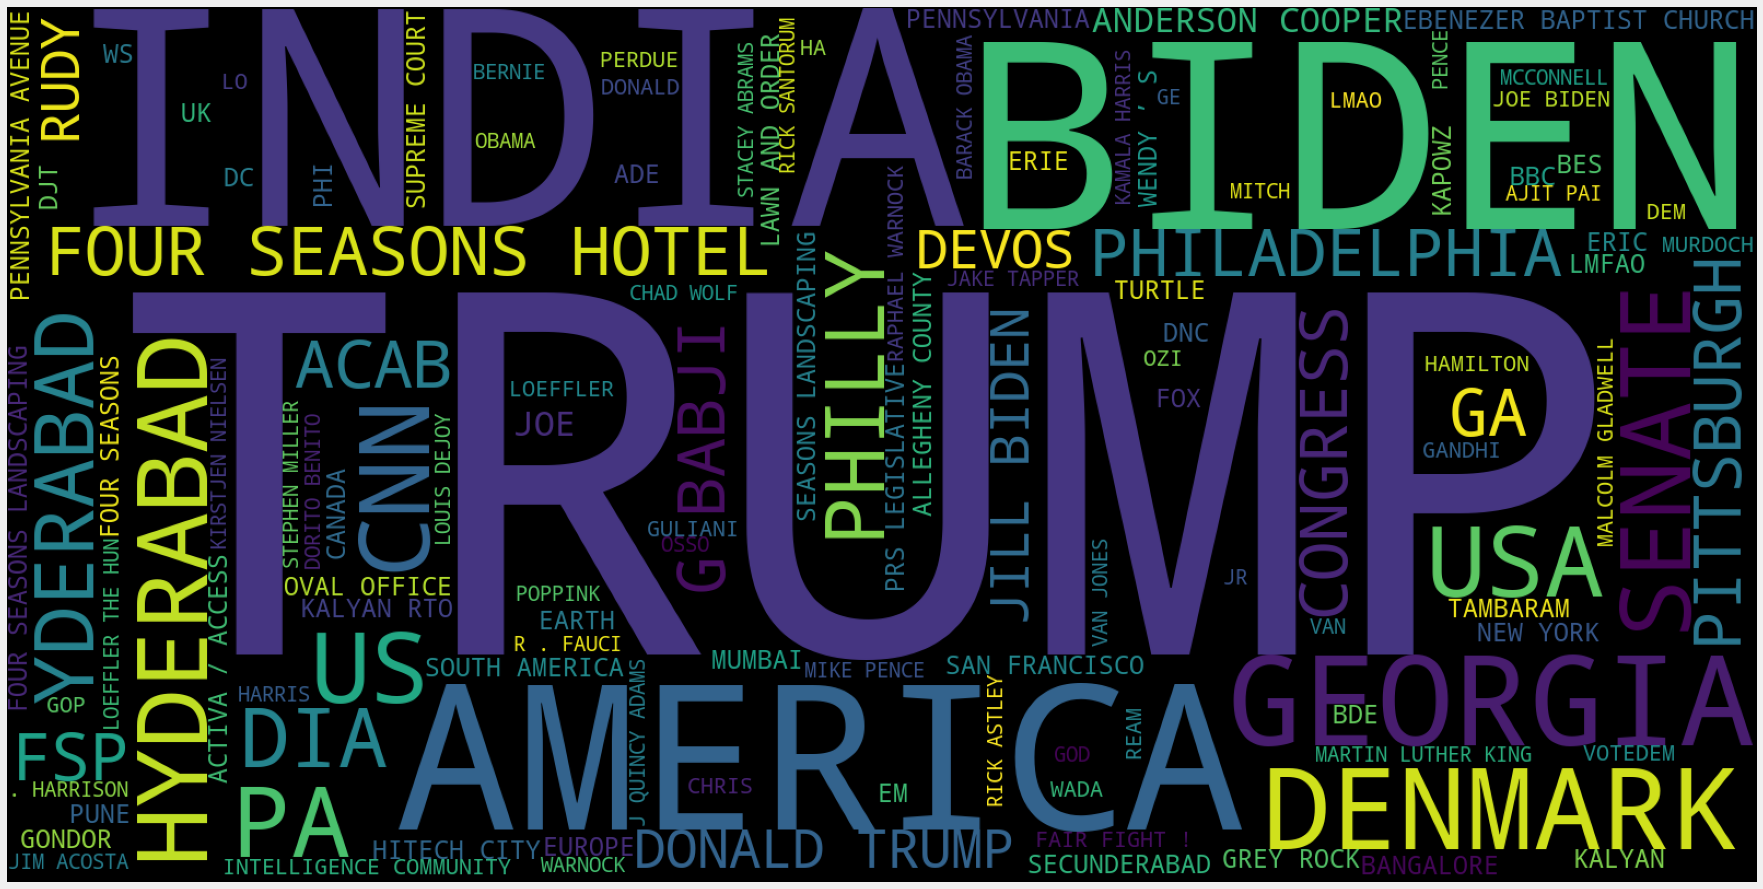

In [ ]:
#yesh = WordCloud(width=800, height=400).generate(result_dict.key())
yesh = WordCloud(width=1600, height=800)
yesh.generate_from_frequencies(result_dict)
plt.figure( figsize=(30,15) )
plt.imshow(yesh)
plt.axis("off")
plt.show()